In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import zscore
from scipy import stats
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint, LinearConstraint

from matplotlib import pyplot as plt
plt.style.use('./hockenberry.mplstyle')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Defining constants and working out save directories

In [3]:
import datetime
import os

year = datetime.date.today().year
month = datetime.date.today().month
base_figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(base_figs_dir):
    os.makedirs(base_figs_dir)

In [123]:
data_tag = 'ecoli_full'
# data_tag = 'ecoli_sparse'
# data_tag = 'ecoli_prot'
# data_tag = 'scer_rna'
# data_tag = 'scer_prot'
save_figs = True
if save_figs:
    temp_figs_dir = base_figs_dir+'/{}'.format(data_tag)
    if not os.path.exists(temp_figs_dir):
        os.makedirs(temp_figs_dir)

In [124]:
# metric = 'CAI'
# metric = 'tAI'
metric = 'roc_semppr_mean'

if save_figs:
    figs_dir = temp_figs_dir + '/{}'.format(metric)
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

# Import data

There are four main data tables to import / wrangle with. 

**First: gene-specific measurements (*i.e.* codon usage biases, predominantly)**

In [125]:
if data_tag in ['ecoli_full', 'ecoli_sparse', 'ecoli_prot']:
    full_df = pd.read_csv('../Data/ecoli_info/current_ecoli_master_table.tsv', sep='\t', index_col=0)
elif data_tag in ['scer_rna', 'scer_prot']:
    full_df = pd.read_csv('../Data/scer_info/current_scer_master_table.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')

full_df['roc_semppr_mean'] = np.log(full_df['roc_semppr_mean'])
    
print(full_df.shape)
full_df = full_df[full_df[metric].isnull()==False]
print(full_df.shape)
full_df.head()

(4355, 11)
(4310, 11)


,gene,start_loc,stop_loc,strand,cds_seq,cds_len,well_behaved,GC_percent_cds,roc_semppr_mean,CAI,tAI
locus_tag,,,,,,,,,,,
b0001,thrL,189,255,+,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,66,True,0.515152,0.217829,0.599506,0.262286
b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,2463,True,0.530654,0.028951,0.330576,0.230564
b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,933,True,0.562701,-0.005235,0.332974,0.216292
b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,1287,True,0.528361,0.159683,0.374815,0.231407
b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,297,True,0.538721,-0.177294,0.356400,0.197715


**Next: meta-data related to experiments / growth conditions**

In [126]:
if data_tag == 'ecoli_full':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_ecoli.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_ecoli_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_prot':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_ecoli_PROTEIN.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(meta_df.shape)
meta_df.head()

(103, 27)


,Sample ID,Study,Project ID,Condition ID,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,...,Additional Details,DOI,GEO,Simple_sample_id,Temperature (C),pH,Growth Rate (1/hr),Alignment,Replicate #,Doubling_time
4,fur__wt_fe__1,Fur,fur,wt_fe,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms5910,GSE54900,fur__wt_fe,37,7.0,1.060606,92.865,2,0.653539
8,fur__delfur_fe2__1,Fur,fur,delfur_fe2,Escherichia coli K-12 MG1655 del_fur,MG1655,M9,glucose(2),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms5910,GSE54900,fur__delfur_fe2,37,7.0,0.619469,93.020,2,1.118938
55,omics__bw_ac__1,Omics,omics,bw_ac,Escherichia coli BW25113,BW25113,M9,acetate(3.5),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_ac,37,7.0,0.203000,97.920,2,3.414518
57,omics__bw_fum__1,Omics,omics,bw_fum,Escherichia coli BW25113,BW25113,M9,fumarate(2.8),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_fum,37,7.0,0.309000,98.130,2,2.243195
59,omics__bw_glc__1,Omics,omics,bw_glc,Escherichia coli BW25113,BW25113,M9,glucose(5),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_glc,37,7.0,0.607500,97.875,2,1.140983


**Next: condition-specific expression information**

In [127]:
if data_tag == 'ecoli_full':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_ecoli.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_ecoli_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_prot':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_ecoli_PROTEIN.tsv', sep='\t', index_col=0)
    name_dict = full_df['gene'].to_dict()
    name_dict = {value:key for key, value in name_dict.items()}
    exp_df.rename(index=name_dict, inplace=True)
    exp_df = exp_df[exp_df.index.isin(name_dict.values())]
elif data_tag == 'scer_rna':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(exp_df.shape)
exp_df.head()

(3923, 103)


,fur__wt_fe,fur__delfur_fe2,omics__bw_ac,omics__bw_fum,omics__bw_glc,omics__bw_pyr,cra_crp__wt_ac,cra_crp__wt_fru,cra_crp__delcra_ac,cra_crp__delcra_fru,...,pal__tartr_ale26_f10,pal__tartr_ale26,pal__tartr_ale28_f10,pal__tartr_ale28,efeU__menFentC_ale39,efeU__menFentC_ale29,efeU__menFentC_ale30,efeU__menFentCubiC_ale36,efeU__menFentCubiC_ale37,efeU__menFentCubiC_ale38
log-TPM,,,,,,,,,,,,,,,,,,,,,
b0002,10.921941,11.221916,9.219835,9.690669,10.213469,10.706351,9.568949,11.198040,8.487038,11.649292,...,7.907166,8.768993,7.738432,8.134838,10.344302,10.273946,11.159558,11.701351,11.902383,11.524586
b0003,10.687397,10.879548,8.963280,9.415289,9.643784,10.197705,8.831856,10.182029,8.546123,11.392722,...,8.026256,8.604928,7.832378,7.992993,10.265772,10.138576,10.353287,10.912852,11.031175,10.694248
b0004,10.254460,10.174903,8.770805,9.533522,9.876957,10.377069,8.680003,10.037740,7.748146,10.717654,...,8.090676,8.717934,7.802900,8.173352,10.712971,10.454710,10.701747,11.128015,11.213320,10.977106
b0005,6.563467,6.331911,4.597347,5.554385,5.909349,6.082721,4.576969,6.058802,3.399998,5.471490,...,3.684667,4.435953,4.044967,4.050593,6.245881,5.842332,6.298730,4.947044,5.603024,5.841291
b0006,6.789173,6.839814,6.488187,6.342374,6.876792,6.650875,6.273174,6.555468,6.647096,6.973928,...,6.635715,6.886069,6.236603,6.675508,7.161943,8.346839,8.104676,7.359833,7.321431,8.081482


**Finally: expression summary statistics calculated from the condition-specific expression matrices**

In [128]:
if data_tag == 'ecoli_full':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_ecoli.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_ecoli_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_prot':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_ecoli_PROTEIN.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(exp_summary_df.shape)
exp_summary_df.head()

(3923, 13)


,count,mean,std,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
log-TPM,,,,,,,,,,,,,
b0002,103.0,10.028859,1.793338,0.056428,9.598118,10.504998,11.080190,12.361644,0.178818,0.031976,0.023834,0.150471,0.215259
b0003,103.0,9.776098,1.009884,7.265206,9.123471,10.023056,10.493901,11.883905,0.103301,0.010671,0.042490,0.151057,0.182895
b0004,103.0,9.849752,1.033603,7.371951,9.149693,10.104900,10.618291,11.992770,0.104937,0.011012,0.038633,0.140572,0.149976
b0005,103.0,5.550056,0.987474,1.878805,4.834444,5.705243,6.201346,7.551687,0.177922,0.031656,0.074243,0.258088,0.412982
b0006,103.0,6.851846,0.407601,5.285927,6.653258,6.849328,7.024589,8.346839,0.059488,0.003539,0.169540,0.243273,0.243724


**Merge some relevant information together with an inner join (indices must appear in both datasets)**

In [129]:
if data_tag in ['ecoli_full', 'ecoli_sparse']:
    full_df = full_df.merge(exp_summary_df, how='inner', left_index=True, right_index=True)
elif data_tag == 'ecoli_prot':
    full_df = full_df.merge(exp_summary_df, how='inner', left_on='gene', right_index=True)
elif data_tag in ['scer_rna', 'scer_prot']:
    print(full_df.shape)
    full_df = full_df[full_df['gene'] != 'hypothetical protein']
    print(full_df.shape)
    assert set(full_df['gene'].str[-1:]) == set(['p'])
    full_df['gene'] = full_df['gene'].str.slice(start=0, stop=-1)
    full_df['gene'] = full_df['gene'].str.upper()
    full_df = full_df.merge(exp_summary_df, how='inner', left_on='gene', right_index=True)
    full_df = full_df.set_index(full_df['gene'])
    full_df = full_df[~full_df.index.duplicated(keep='first')]
print(full_df.shape)
full_df.head()

(3859, 24)


,gene,start_loc,stop_loc,strand,cds_seq,cds_len,well_behaved,GC_percent_cds,roc_semppr_mean,CAI,...,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,2463,True,0.530654,0.028951,0.330576,...,0.056428,9.598118,10.504998,11.080190,12.361644,0.178818,0.031976,0.023834,0.150471,0.215259
b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,933,True,0.562701,-0.005235,0.332974,...,7.265206,9.123471,10.023056,10.493901,11.883905,0.103301,0.010671,0.042490,0.151057,0.182895
b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,1287,True,0.528361,0.159683,0.374815,...,7.371951,9.149693,10.104900,10.618291,11.992770,0.104937,0.011012,0.038633,0.140572,0.149976
b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,297,True,0.538721,-0.177294,0.356400,...,1.878805,4.834444,5.705243,6.201346,7.551687,0.177922,0.031656,0.074243,0.258088,0.412982
b0006,yaaA,5682,6459,-,ATGCTGATTCTTATTTCACCTGCGAAAACGCTTGATTACCAAAGCC...,777,True,0.496782,0.030850,0.335276,...,5.285927,6.653258,6.849328,7.024589,8.346839,0.059488,0.003539,0.169540,0.243273,0.243724


# Find the individual conditions whose gene expression is most (and least) correlated with CUB

In [130]:
###Working with the full expression dataset here
temp_df = exp_df.loc[full_df.index]

corrs = []
growth = []
min_r2 = 1
min_col = (np.nan, '')
max_r2 = 0
max_col = (np.nan, '')
for i, col in enumerate(temp_df.columns):
    ###Test correlation between each column (individual condition expression) against pre-defined metric
    r, p = stats.pearsonr(full_df[metric], temp_df[col])
    r2 = r**2
    corrs.append(r2)
    ###Ensure that I can match the expression column to its proper meta-data
    assert meta_df[meta_df['Simple_sample_id']==col].shape[0]==1
    ###And extract the growth rate
    growth.append(meta_df[meta_df['Simple_sample_id']==col].iloc[0]['Growth Rate (1/hr)'])
    if r2 > max_r2:
        max_r2 = r2
        max_col = (i, col)
    if r2 < min_r2:
        min_r2 = r2
        min_col = (i, col)
print(max_col, max_r2)
print(min_col, min_r2)

(15, 'rpoB__rpoBE672K_lb') 0.2787319491334621
(84, 'fps__fps_serB_ale4') 0.1079454326456038


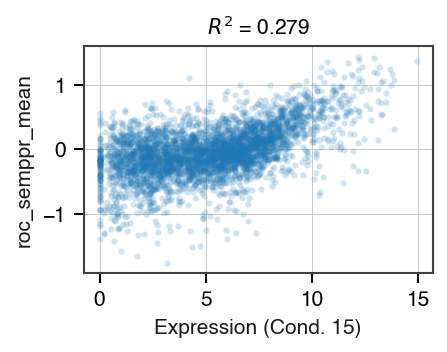

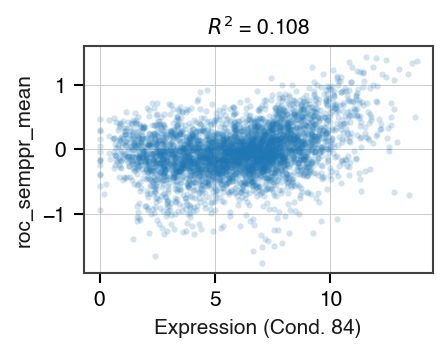

In [131]:
assert all(temp_df.index == full_df.index)
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(temp_df[max_col[1]], full_df[metric], marker='.', linestyle='', alpha=0.2)
if 'ecoli' in data_tag:
    ax.set_xlabel('Expression (Cond. {})'.format(max_col[0]))
elif data_tag == 'scer_rna':
    ax.set_xlabel('Relative RNA abundance, Condition {}'.format(max_col[0]))
elif data_tag == 'scer_prot':
    ax.set_xlabel('Relative protein abundance, Condition {}'.format(max_col[0]))
ax.set_ylabel(metric)
ax.set_title(r"$R^2$ = {:.3f}".format(max_r2))
if save_figs:
    plt.savefig(figs_dir+'/{}_vs_Cond{}.pdf'.format(metric, max_col[0]), bbox_inches='tight')

fig, ax = plt.subplots(figsize=(3,2))
ax.plot(temp_df[min_col[1]], full_df[metric], marker='.', linestyle='', alpha=0.2)
if 'ecoli' in data_tag:
    ax.set_xlabel('Expression (Cond. {})'.format(min_col[0]))
elif data_tag == 'scer_rna':
    ax.set_xlabel('Relative RNA abundance, Condition {}'.format(min_col[0]))
elif data_tag == 'scer_prot':
    ax.set_xlabel('Relative protein abundance, Condition {}'.format(min_col[0]))
ax.set_ylabel(metric)
ax.set_title(r"$R^2$ = {:.3f}".format(min_r2))
if save_figs:
    plt.savefig(figs_dir+'/{}_vs_Cond{}.pdf'.format(metric, min_col[0]), bbox_inches='tight')

SpearmanrResult(correlation=0.5573062871047282, pvalue=9.70081519256669e-10)
(0.5770084114362019, 1.7775136803964363e-10)


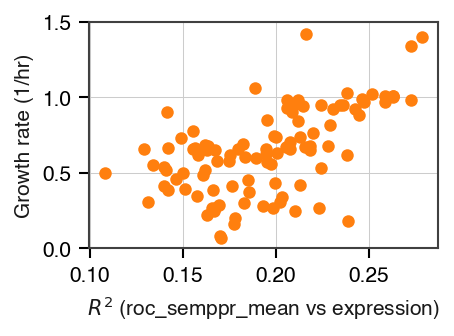

In [134]:
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(corrs, growth, marker='o', linestyle='', c=color_cycle[1])
ax.set_xlabel('$R^2$ ({} vs expression)'.format(metric))
ax.set_ylabel('Growth rate (1/hr)')
ax.set_ylim(0, round(max(growth))+ 0.5)
print(stats.spearmanr(corrs, growth))
print(stats.pearsonr(corrs, growth))
ax.set_title('')
if save_figs:
    plt.savefig(figs_dir+'/growth_vs_cond_corrs.pdf', bbox_inches='tight')

# Determine which expression-based summary statistics are *most* correlated with CUB metrics

In [135]:
print(full_df.columns)

Index(['gene', 'start_loc', 'stop_loc', 'strand', 'cds_seq', 'cds_len',
       'well_behaved', 'GC_percent_cds', 'roc_semppr_mean', 'CAI', 'tAI',
       'count', 'mean', 'std', 'min', '25_percentile', '50_percentile',
       '75_percentile', 'max', 'cv', 'noise', 'lin_slope', 'lin_r',
       'spearmans_rho'],
      dtype='object')


In [136]:
sstats = ['mean', '50_percentile', 'max', 'min']

cub_corrs = []
for sstat in sstats:
    r, p = stats.pearsonr(full_df[metric], full_df[sstat])
    r2 = r**2
    print(sstat, r2, p)
    cub_corrs.append(r2)

other_metrics = ['GC_percent_cds', 'cds_len']
other_corrs = []
for other_metric in other_metrics:
    r, p = stats.pearsonr(full_df[other_metric], full_df[sstat])
    r2 = r**2
    print(other_metric, r2, p)
    other_corrs.append(r2)

mean 0.2224765159154022 4.739872218024698e-213
50_percentile 0.20872619079099408 2.3539081323573067e-198
max 0.20763494580869124 3.366476508796639e-197
min 0.2196602731728448 5.0893367367590316e-210
GC_percent_cds 0.035422310432745525 4.221344372468868e-32
cds_len 0.002762820293247395 0.0010891286251271614


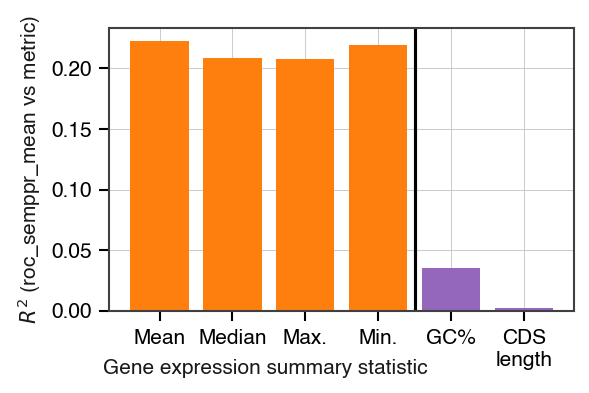

In [142]:
fig, ax = plt.subplots(figsize=(4,2.5))
ax.bar(np.arange(len(cub_corrs)), cub_corrs, facecolor=color_cycle[1])
ax.set_ylabel('$R^2$ ({} vs metric)'.format(metric))


ax.axvline(len(cub_corrs)-0.5, c='k')
ax.bar(np.arange(len(cub_corrs), len(cub_corrs)+len(other_corrs)), other_corrs, facecolor=color_cycle[4])

ax.set_xticks(np.arange(len(cub_corrs) + len(other_corrs)))
ax.set_xticklabels(['Mean', 'Median', 'Max.', 'Min.', 'GC%', 'CDS\nlength'], rotation=0)
ax.set_xlabel('Gene expression summary statistic', labelpad=(0, 10, 0, 0))
ax.xaxis.set_label_coords(0.335, -0.17)



if save_figs:
    plt.savefig(figs_dir+'/{}_summary_stats_corr.pdf'.format(metric), bbox_inches='tight')

# Regression analysis to assess predictors of CUB

In [147]:
print(full_df.columns)

Index(['gene', 'start_loc', 'stop_loc', 'strand', 'cds_seq', 'cds_len',
       'well_behaved', 'GC_percent_cds', 'roc_semppr_mean', 'CAI', 'tAI',
       'count', 'mean', 'std', 'min', '25_percentile', '50_percentile',
       '75_percentile', 'max', 'cv', 'noise', 'lin_slope', 'lin_r',
       'spearmans_rho'],
      dtype='object')


In [148]:
model_correlations = []

In [149]:
###Model 1, average expression
model1_params = []
fitted = smf.ols('zscore({}) ~ zscore(mean)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model_correlations.append(fitted.rsquared_adj)
model1_params = list(zip(params, cis.values))
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     zscore(roc_semppr_mean)   R-squared:                       0.222
Model:                                 OLS   Adj. R-squared:                  0.222
Method:                      Least Squares   F-statistic:                     1104.
Date:                     Fri, 23 Apr 2021   Prob (F-statistic):          4.74e-213
Time:                             16:53:07   Log-Likelihood:                -4990.1
No. Observations:                     3859   AIC:                             9984.
Df Residuals:                         3857   BIC:                             9997.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.584e-18      0.014   3.93e-16      1.000      -0.028       0.028
zscore(mean)     0.4717      0.014     33.221      0.000       0.444       0.500
==============================================================================
Omnibus:                      155.089   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.845
Skew:                          -0.319   Prob(JB):                     2.82e-61
Kurtosis:                       4.152   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
###Model 2, growth correlation
model2_params = []
fitted = smf.ols('zscore({}) ~ zscore(lin_r)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model2_params = list(zip(params, cis.values))
model_correlations.append(fitted.rsquared_adj)


fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     zscore(roc_semppr_mean)   R-squared:                       0.208
Model:                                 OLS   Adj. R-squared:                  0.208
Method:                      Least Squares   F-statistic:                     1011.
Date:                     Fri, 23 Apr 2021   Prob (F-statistic):          2.78e-197
Time:                             16:53:11   Log-Likelihood:                -5026.4
No. Observations:                     3859   AIC:                         1.006e+04
Df Residuals:                         3857   BIC:                         1.007e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.584e-18      0.014    3.9e-16      1.000      -0.028       0.028
zscore(lin_r)     0.4558      0.014     31.799      0.000       0.428       0.484
==============================================================================
Omnibus:                      109.780   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.349
Skew:                          -0.162   Prob(JB):                     3.52e-51
Kurtosis:                       4.157   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [151]:
###Model 3, all together
model3_params = []
fitted = smf.ols('zscore({}) ~ zscore(mean) + zscore(lin_r)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model3_params = list(zip(params, cis.values))
model_correlations.append(fitted.rsquared_adj)
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     zscore(roc_semppr_mean)   R-squared:                       0.314
Model:                                 OLS   Adj. R-squared:                  0.313
Method:                      Least Squares   F-statistic:                     880.9
Date:                     Fri, 23 Apr 2021   Prob (F-statistic):          7.98e-316
Time:                             16:53:13   Log-Likelihood:                -4749.6
No. Observations:                     3859   AIC:                             9505.
Df Residuals:                         3856   BIC:                             9524.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.584e-18      0.013   4.19e-16      1.000      -0.026       0.026
zscore(mean)      0.3506      0.014     24.391      0.000       0.322       0.379
zscore(lin_r)     0.3253      0.014     22.628      0.000       0.297       0.353
==============================================================================
Omnibus:                      159.623   Durbin-Watson:                   1.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              295.330
Skew:                          -0.319   Prob(JB):                     7.41e-65
Kurtosis:                       4.196   Cond. No.                         1.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

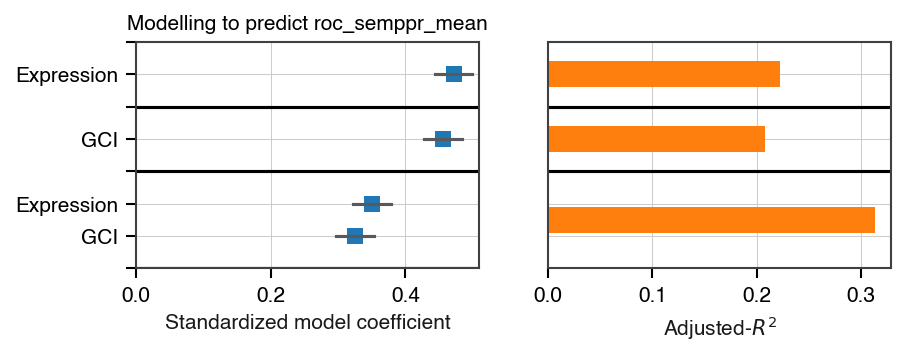

In [153]:
counter = 0
fig, ax_arr = plt.subplots(figsize=(6.5, 2), ncols=2, sharey=True)
for model_params in [model1_params, model2_params, model3_params]:
    for i,ind_param in enumerate(model_params[1:]):
        ax_arr[0].plot(ind_param[0], -i+counter, marker='s', markersize=8, color=color_cycle[0])
        ax_arr[0].plot([ind_param[1][0], ind_param[1][1]], [-i+counter, -i+counter], marker='', color='0.35')
    ax_arr[0].axhline(-i+counter-1, c='k')
    counter -= 2
ax_arr[0].set_ylim(-6, 1)
ax_arr[0].set_yticks(range(-6, 2))
labels_top_to_bottom = ['', 'Expression', '',\
                    'GCI', '',\
                    'Expression', 'GCI', '']
ax_arr[0].set_yticklabels(labels_top_to_bottom[::-1])
ax_arr[0].set_xlabel('Standardized model coefficient')
# ax_arr[0].set_xlim(0, 0.6)
ax_arr[0].set_xlim(0)
ax_arr[0].set_title('Modelling to predict {}'.format(metric))

ax_arr[1].barh(0, model_correlations[0], 0.8, facecolor=color_cycle[1])
ax_arr[1].barh(-2, model_correlations[1], 0.8, facecolor=color_cycle[1])
ax_arr[1].barh(-4.5, model_correlations[2], 0.8, facecolor=color_cycle[1])
ax_arr[1].axhline(-1, c='k')
ax_arr[1].axhline(-3, c='k')
ax_arr[1].set_ylim(-6, 1)
ax_arr[1].set_yticks(range(-6, 2))
ax_arr[1].set_xlabel('Adjusted-$R^2$');
ax_arr[1].tick_params(axis='y', which='both', left=False)

# plt.subplots_adjust(wspace=1.0)

if save_figs:
    plt.savefig(figs_dir+'/{}_model_comp_R2.pdf'.format(metric), bbox_inches='tight')

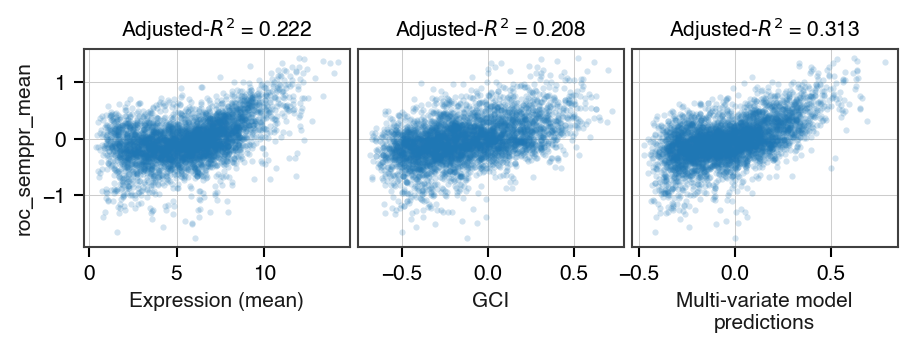

In [154]:
assert len(model_correlations)==3

###Model1
fig, ax_arr = plt.subplots(figsize=(7, 1.75), ncols=3, sharey=True)
ax_arr[0].plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
ax_arr[0].set_xlabel('Expression (mean)')
ax_arr[0].set_ylabel('{}'.format(metric))
ax_arr[0].set_title('Adjusted-$R^2$ = {:.3f}'.format(model_correlations[0]))

###Model 2
ax_arr[1].plot(full_df['lin_r'], full_df[metric], marker='.', linestyle='', alpha=0.2)
ax_arr[1].set_xlabel('GCI')
ax_arr[1].set_title('Adjusted-$R^2$ = {:.3f}'.format(model_correlations[1]))

###Model 3
fitted = smf.ols('{} ~ mean + lin_r'.format(metric), data=full_df).fit()
ax_arr[2].plot(fitted.predict(), full_df[metric], marker='.', linestyle='', alpha=0.2)
ax_arr[2].set_xlabel('Multi-variate model\npredictions')
ax_arr[2].set_title('Adjusted-$R^2$ = {:.3f}'.format(model_correlations[2]))

ax_arr[1].tick_params(axis='y', which='both', left=False)
ax_arr[2].tick_params(axis='y', which='both', left=False)
plt.subplots_adjust(wspace=0.03)
if save_figs:
    plt.savefig(figs_dir+'/{}_scatter_set.pdf'.format(metric), bbox_inches='tight')

## Robustness check 

**Visually ensure that results are consistent when using with value from the lowest/highest correlation condition *rather* than the mean. Just quickly looking at effect sizes here rather than anything more complicated.**

In [155]:
temp_df = full_df.merge(exp_df, left_index=True, right_index=True, how='inner')
temp_df.rename(columns={min_col[1]:'min_col',max_col[1]:'max_col'}, inplace=True)

**Condition with the minimum correlation (identified previously)**

In [156]:
fitted = smf.ols('zscore({}) ~ zscore({}) + zscore(lin_r)'.format(metric, 'min_col'), data=temp_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     zscore(roc_semppr_mean)   R-squared:                       0.269
Model:                                 OLS   Adj. R-squared:                  0.269
Method:                      Least Squares   F-statistic:                     710.4
Date:                     Fri, 23 Apr 2021   Prob (F-statistic):          2.17e-263
Time:                             16:54:05   Log-Likelihood:                -4870.4
No. Observations:                     3859   AIC:                             9747.
Df Residuals:                         3856   BIC:                             9766.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.584e-18      0.014   4.06e-16      1.000      -0.027       0.027
zscore(min_col)     0.2525      0.014     18.021      0.000       0.225       0.280
zscore(lin_r)       0.4088      0.014     29.176      0.000       0.381       0.436
==============================================================================
Omnibus:                      153.006   Durbin-Watson:                   1.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.676
Skew:                          -0.303   Prob(JB):                     9.25e-63
Kurtosis:                       4.187   Cond. No.                         1.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Condition with the maximum correlation (identified previously)**

In [157]:
fitted = smf.ols('zscore({}) ~ zscore({}) + zscore(lin_r)'.format(metric, 'max_col'), data=temp_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     zscore(roc_semppr_mean)   R-squared:                       0.335
Model:                                 OLS   Adj. R-squared:                  0.334
Method:                      Least Squares   F-statistic:                     969.1
Date:                     Fri, 23 Apr 2021   Prob (F-statistic):               0.00
Time:                             16:54:09   Log-Likelihood:                -4689.9
No. Observations:                     3859   AIC:                             9386.
Df Residuals:                         3856   BIC:                             9405.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.584e-18      0.013   4.25e-16      1.000      -0.026       0.026
zscore(max_col)     0.4029      0.015     27.106      0.000       0.374       0.432
zscore(lin_r)       0.2672      0.015     17.979      0.000       0.238       0.296
==============================================================================
Omnibus:                      149.751   Durbin-Watson:                   1.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.176
Skew:                          -0.300   Prob(JB):                     6.49e-61
Kurtosis:                       4.168   Cond. No.                         1.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [160]:
print(stats.spearmanr(temp_df['lin_r'], temp_df['min_col']))
print(stats.spearmanr(temp_df['lin_r'], temp_df['max_col']))
print(stats.spearmanr(temp_df['lin_r'], temp_df['mean']))

SpearmanrResult(correlation=0.1778002941043841, pvalue=8.931457598937914e-29)
SpearmanrResult(correlation=0.4489379956805021, pvalue=8.826713894714579e-191)
SpearmanrResult(correlation=0.35722810797632804, pvalue=1.635968815446177e-116)


# Visualizing various multi-variate models for robustness

**First, the additive model without z-score standardization**

In [115]:
fitted = smf.ols('{} ~ mean + lin_r'.format(metric), data=full_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        roc_semppr_mean   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     380.2
Date:                Fri, 23 Apr 2021   Prob (F-statistic):          5.15e-140
Time:                        15:20:51   Log-Likelihood:                -450.56
No. Observations:                1939   AIC:                             907.1
Df Residuals:                    1936   BIC:                             923.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0985      0.012     -8.417      0.000      -0.121      -0.076
mean           0.1469      0.006     24.708      0.000       0.135       0.159
lin_r          0.1856      0.015     12.734      0.000       0.157       0.214
==============================================================================
Omnibus:                      109.670   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.840
Skew:                          -0.283   Prob(JB):                     1.28e-65
Kurtosis:                       4.838   Cond. No.                         4.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

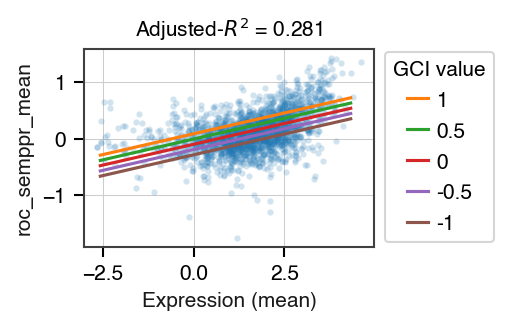

In [116]:
# growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
growth_corrs = [-1, -0.5, 0, 0.5, 1]
#Plot the resulting data
fig, ax = plt.subplots(figsize=(2.5,1.75))
x_vals = np.linspace(full_df['mean'].quantile(0.001), full_df['mean'].quantile(0.999), 100)
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, fitted.params[0] +\
            (fitted.params[1]*x_vals) +\
            (fitted.params[2]*i), label=i)
ax.set_xlabel('Expression (mean)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GCI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-$R^2$ = {:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/{}_best_additive.pdf'.format(metric), bbox_inches='tight')

**Next, an interaction effect**

In [117]:
fitted = smf.ols('{} ~ mean * lin_r'.format(metric), data=full_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        roc_semppr_mean   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     261.6
Date:                Fri, 23 Apr 2021   Prob (F-statistic):          1.75e-142
Time:                        15:20:55   Log-Likelihood:                -441.75
No. Observations:                1939   AIC:                             891.5
Df Residuals:                    1935   BIC:                             913.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0972      0.012     -8.335      0.000      -0.120      -0.074
mean           0.1458      0.006     24.601      0.000       0.134       0.157
lin_r          0.0857      0.028      3.075      0.002       0.031       0.140
mean:lin_r     0.0535      0.013      4.202      0.000       0.029       0.078
==============================================================================
Omnibus:                      108.547   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.392
Skew:                          -0.251   Prob(JB):                     1.98e-69
Kurtosis:                       4.914   Cond. No.                         9.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

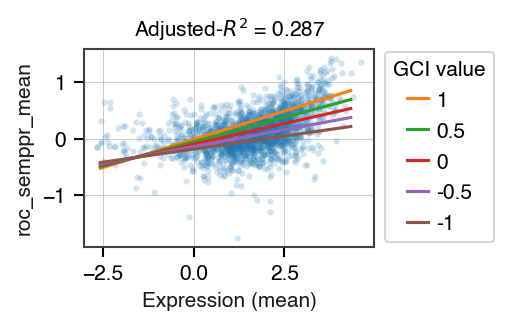

In [118]:
# growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
growth_corrs = [-1, -0.5, 0, 0.5, 1]

#Plot the resulting data
fig, ax = plt.subplots(figsize=(2.5,1.75))
x_vals = np.linspace(full_df['mean'].quantile(0.001), full_df['mean'].quantile(0.999), 100)
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, fitted.params[0] +\
            (fitted.params[1]*x_vals) +\
            (fitted.params[2]*i) +\
            (fitted.params[3]*x_vals*i), label=i)
ax.set_xlabel('Expression (mean)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GCI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-$R^2$ = {:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/{}_best_interaction.pdf'.format(metric), bbox_inches='tight')

**Next, a basic polynomial fit**

In [119]:
fitted = smf.ols('{} ~ np.power(mean, 2) + np.power(mean, 1) + lin_r'.format(metric), data=full_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        roc_semppr_mean   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     352.9
Date:                Fri, 23 Apr 2021   Prob (F-statistic):          8.55e-183
Time:                        15:20:59   Log-Likelihood:                -348.64
No. Observations:                1939   AIC:                             705.3
Df Residuals:                    1935   BIC:                             727.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0972      0.011     -8.755      0.000      -0.119      -0.075
np.power(mean, 2)     0.0465      0.003     14.646      0.000       0.040       0.053
np.power(mean, 1)     0.0318      0.010      3.281      0.001       0.013       0.051
lin_r                 0.1638      0.014     11.775      0.000       0.137       0.191
==============================================================================
Omnibus:                      165.004   Durbin-Watson:                   1.545
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.634
Skew:                          -0.495   Prob(JB):                     2.25e-88
Kurtosis:                       5.004   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

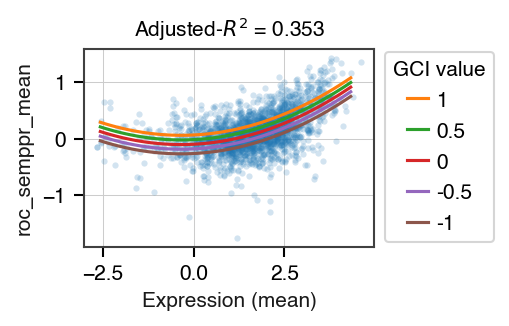

In [120]:
# growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
growth_corrs = [-1, -0.5, 0, 0.5, 1]

#Plot the resulting data
fig, ax = plt.subplots(figsize=(2.5,1.75))
x_vals = np.linspace(full_df['mean'].quantile(0.001), full_df['mean'].quantile(0.999), 100)
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, fitted.params[0] +\
            (fitted.params[1]*np.power(x_vals, 2)) +\
            (fitted.params[2]*np.power(x_vals, 1)) +\
            (fitted.params[3]*i), label=i)
ax.set_xlabel('Expression (mean)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GCI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-$R^2$ = {:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/{}_poly_additive.pdf'.format(metric), bbox_inches='tight')

**And a polynomial with both interaction terms just for over-completeness**

In [121]:
fitted = smf.ols('{} ~ np.power(mean, 2) * lin_r + np.power(mean, 1) * lin_r'.format(metric), data=full_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        roc_semppr_mean   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     222.1
Date:                Fri, 23 Apr 2021   Prob (F-statistic):          1.56e-187
Time:                        15:21:01   Log-Likelihood:                -331.76
No. Observations:                1939   AIC:                             675.5
Df Residuals:                    1933   BIC:                             708.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0976      0.011     -8.795      0.000      -0.119      -0.076
np.power(mean, 2)           0.0468      0.003     14.517      0.000       0.040       0.053
lin_r                       0.0451      0.027      1.670      0.095      -0.008       0.098
np.power(mean, 2):lin_r     0.0104      0.006      1.622      0.105      -0.002       0.023
np.power(mean, 1)           0.0301      0.010      3.064      0.002       0.011       0.049
np.power(mean, 1):lin_r     0.0367      0.022      1.633      0.103      -0.007       0.081
==============================================================================
Omnibus:                      154.719   Durbin-Watson:                   1.536
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              382.148
Skew:                          -0.462   Prob(JB):                     1.04e-83
Kurtosis:                       4.969   Cond. No.                         27.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

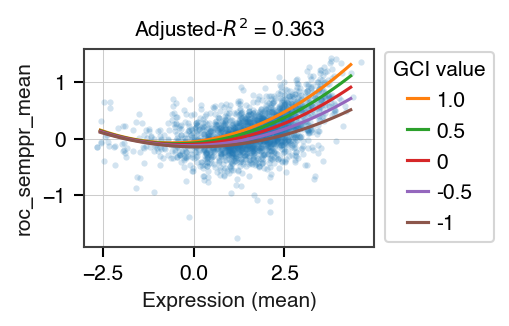

In [122]:
# growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
growth_corrs = [-1, -0.5, 0, 0.5, 1.0]
#Plot the resulting data
fig, ax = plt.subplots(figsize=(2.5,1.75))
x_vals = np.linspace(full_df['mean'].quantile(0.001), full_df['mean'].quantile(0.999), 100)
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, fitted.params[0] +\
            (fitted.params[1]*np.power(x_vals, 2)) +\
            (fitted.params[2]*i) +\
            (fitted.params[3]*np.power(x_vals, 2)*i) +\
            (fitted.params[4]*np.power(x_vals, 1)) +\
            (fitted.params[5]*np.power(x_vals, 1)*i), label=i)
ax.set_xlabel('Expression (mean)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GCI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-$R^2$ = {:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/{}_poly_interaction.pdf'.format(metric), bbox_inches='tight')

# Finally, some mixed linear models

There are a few benefits and a few problems to the following analysis. **If** you're going to discretize data, you should do it using a mixed linear model as opposed to fixed-effects. Here, I'm only *really* interested in dealing with discrete categories as a visual companion, so this framework and the resulting plots have a few nice visual perks. But the above analyses that do not discretize the growth rate variable are far more statistically *correct* in my opinion.

Mixed effect models are difficult to summarize, we don't get the benefit of an R2 anymore (the term doesn't have much meaning here). We also can't directly compare models using the log-transformed response variable directly with the non-log-transformed version. Apparently, the log-likelihoods, AICs, etc. are on different scales and while there appear to be some ways to map one onto the other I haven't dug into this yet. 

There are some nuanced issues with fitting to the log-transformed data since the error distributions make some incorrect assumptions when doing this, but note that doesn't seem to ever stop anyone from log-scaling data and fitting linear lines so I'm putting it out there as a relatively minor issue here.

Also, the `reml` flag seems to be a "choose-as-you-see-fit" parameter. There are a lot of warnings that crop up, but the results even with a bunch of warnings for basic `mixedlm` models look almost the same as the `ols` models so I didn't find this to be too concerning. 

And again, I can't stress this enough that we're doing this mainly for visualization purposes, binning / discretizing continuous data is **always** a bad idea (I've yet to ever see convincing evidence to the contrary). 

In [ ]:
reml=True
n_cats = 5
full_df['growth_cat'] = pd.qcut(full_df['lin_r'], n_cats, labels=list(range(n_cats)))

## Linear model with a fixed slope and random intercept

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('{} ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
    line = fitted.params[0]+fitted.random_effects[i]['Group'] + ((fitted.params[1])*x_vals)
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Linear with a random slope and fixed intercept

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('{} ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     re_formula='~0+mean',
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
    line = fitted.params[0] + ((fitted.params[1]+fitted.random_effects[i]['mean'])*x_vals)
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Linear with random effect slope AND random intercepts

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('{} ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     re_formula='~mean',
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
    line = fitted.params[0]+fitted.random_effects[i]['Group'] + ((fitted.params[1]+fitted.random_effects[i]['mean'])*x_vals)
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Exponential with random slopes and random intercepts

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('np.log({}) ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     re_formula='~mean',
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
    line = np.exp(fitted.params[0]+fitted.random_effects[i]['Group'] + ((fitted.params[1]+fitted.random_effects[i]['mean'])*x_vals))
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

# Scratch

In [ ]:
full_df

In [ ]:
full_df.hist('lin_r')

In [ ]:
metric = 'CAI'
fitted = smf.ols('zscore({}) ~ zscore(mean)'.format(metric), data=full_df).fit()
fitted.summary()
# fitted = smf.ols('zscore({}) ~ zscore(lin_r)'.format(metric), data=full_df).fit()
# fitted.summary()
# fitted = smf.ols('zscore({}) ~ zscore(mean) + zscore(lin_r)'.format(metric), data=full_df).fit()
# fitted.summary()
# fitted = smf.ols('zscore({}) ~ zscore(mean) + zscore(GC_percent_cds)'.format(metric), data=full_df).fit()
# fitted.summary()

In [ ]:
fig, ax = plt.subplots()
# ax.plot(full_df['mean'], full_df['CAI'], linestyle='', marker='.')
ax.plot(zscore(full_df['mean']), zscore(full_df['CAI']), linestyle='', marker='.')
# ax.semilogx(full_df['mean'], full_df['CAI'], linestyle='', marker='.')

In [ ]:
full_df['mean'].min()